# **M1 Exam Submission part 2**

## **Table of Contents**

#### I. Import Libraries and Data
#### II. Data Preparation
#### III. Model Development
#### IV. Model Evaluation

### Funding Duration Prediction:
### Target: funding_duration_days (Time to Secure Loan)

### Problem Statement:

The objective is to predict how long it will take for a loan request to be fully funded, based on factors such as the borrower's country, sector, activity type, loan amount, and number of lenders. By understanding these relationships, the model can provide insights into which factors lead to faster or slower funding times.
Type of Model:
The model will use regression, as the target variable (funding_duration_days) represents a continuous numerical value. The goal is to predict the number of days required to secure full funding for a loan based on the given features.
### Objective:
This model aims to assist lending platforms and financial institutions in forecasting how long a loan will take to be fully funded after a request is made. This can help in optimizing loan approval strategies, better managing borrower expectations, and allocating resources efficiently to improve funding success rates.

In [265]:
# install all requried libraries
!pip install -r https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/requirements.txt

In [266]:
#import libraries
import pandas as pd             # for data manipulation
import numpy as np              # for mathematical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for data visualization
from scipy.stats import zscore  # for standardizing data & removing outliers
import geopandas as gpd # for   # !!! check usecase of geopandas...
import altair as alt            # for interactive visualization
from vega_datasets import data  # for data visualization

#additional libraries for importing data from github
import requests                 # used for importing data
import io                       # used for converting response content to a file-like object for pandas

# library used for gender mapping - section 4
import re

In [243]:
# definition of url-paths for datasets
url1 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/kiva_loans_part_0.csv?token=GHSAT0AAAAAACW5CC7BUKRXCRU7APTH5Q4EZX5FNYA'
url2 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/kiva_loans_part_1.csv?token=GHSAT0AAAAAACW5CC7B5N3TSECZ4BHAIWIOZX5FN6A'
url3 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/kiva_loans_part_2.csv?token=GHSAT0AAAAAACW5CC7AP4TAV3AH63VJT4RAZX5FN6Q'

# loading the urls into requests to download data
response1 = requests.get(url1)
response2 = requests.get(url2)
response3 = requests.get(url3)

# convert the response content to a file-like object for pandas using io.StringIO
# the advantage of StringIO is that it allows us to import the data without having to save it as a file for pandas
data_part1 = pd.read_csv(io.StringIO(response1.text))
data_part2 = pd.read_csv(io.StringIO(response2.text))
data_part3 = pd.read_csv(io.StringIO(response3.text))

# We can see, that the imported loan dataset consists of 3 parts. We will like to combine these to one dataset
data = pd.concat([data_part1, data_part2, data_part3])

### Data Preparation

In [244]:
# Dropping unnecessary columns
data = data.drop(['tags', 'use', 'currency', 'country_code', 'partner_id'], axis=1)

# we want to remove the missing rows from the dataset
# storing length of rows for comparing, >> before dropna.. <<
data_rows = len(data)

# dropping missing values
data.dropna(inplace=True)

# storing the now cleaned dataset
cleaned_rows = len(data)

# check..
drops = data_rows - cleaned_rows

# print the dropped rows and percentage of data removed
print(f"Number of dropped rows: {drops}")
print(f'In percentage {(drops / data_rows) * 100:.2f} % of the data was removed')
# check after cleaning
data.isna().sum()

Number of dropped rows: 97078
In percentage 14.46 % of the data was removed


id                    0
funded_amount         0
loan_amount           0
activity              0
sector                0
country               0
region                0
posted_time           0
disbursed_time        0
funded_time           0
term_in_months        0
lender_count          0
borrower_genders      0
repayment_interval    0
date                  0
dtype: int64

### Filter countries to only include top 20 based on total loan_amount

In [245]:
# what is the total amount of loan_amount for each country?
country_loans = data.groupby('country')['loan_amount'].sum()

# we would like the top 20 countries
country_top_20 = country_loans.sort_values(ascending=False).head(20)

# using index we create a new variable with the top 20 countries
data = data[data['country'].isin(country_top_20.index)]

### Gender Mapping

In [246]:
### Gender Mapping (creating groups of male, female, and mixed gender groups)
# count the number of male and female borrowers by searching for occurrences of 'male' and 'female' in the 'borrower_genders' column
data['male_borrowers'] = data['borrower_genders'].apply(lambda x: len(re.findall(r'\bmale', x)))
data['female_borrowers'] = data['borrower_genders'].apply(lambda x: len(re.findall(r'\bfemale', x)))

# calculate the total number of borrowers by adding male and female borrower counts
data['borrowers_count'] = data['male_borrowers'] + data['female_borrowers']

# handle cases where 'borrowers_count' is 0 by replacing it with 1 to avoid division by zero
data['male_borrower_ratio'] = data['male_borrowers'] / data['borrowers_count'].replace(0, 1)

# function to classify the gender group based on the ratio of male borrowers
# if the ratio is 1, it means all borrowers are male, so return 'male(s)'
# if the ratio is 0, all borrowers are female, so return 'female(s)'
# otherwise, return 'mixed gender group' for groups with both male and female borrowers
def classify_genders(ratio):
    if ratio == 1:
        return 'male(s)'
    elif ratio == 0:
        return 'female(s)'
    else:
        return 'mixed gender group'

# apply the gender classification function to each row based on the 'male_borrower_ratio'
data['gender_class'] = data['male_borrower_ratio'].apply(classify_genders)

# print of the first 10 rows of new added columns to see the borrower genders, counts, ratios, and classifications
data[['borrower_genders', 'male_borrowers', 'female_borrowers', 'borrowers_count', 'male_borrower_ratio', 'gender_class']].head(10)

,borrower_genders,male_borrowers,female_borrowers,borrowers_count,male_borrower_ratio,gender_class
0,female,0,1,1,0.0,female(s)
1,"female, female",0,2,2,0.0,female(s)
3,female,0,1,1,0.0,female(s)
4,female,0,1,1,0.0,female(s)
7,female,0,1,1,0.0,female(s)
8,female,0,1,1,0.0,female(s)
9,female,0,1,1,0.0,female(s)
10,female,0,1,1,0.0,female(s)
11,female,0,1,1,0.0,female(s)
12,female,0,1,1,0.0,female(s)


In [247]:
### Removing outliers based on loan_amount
# calculate z-scores for loan_amount (our outlier detection)
z_scores = zscore(data['loan_amount'])

# get boolean array indicating the presence of outliers
# using 2 & -2 z_scores to get 95% of data within 2 standard deviations
data['outlier_loan_amount'] = (z_scores > 2) | (z_scores < -2)


#removing outliers
data_clean = data[~data['outlier_loan_amount']]

# check amount of outliers
data['outlier_loan_amount'].sum()

19416

### Calculating funding duration (time between posted_time and funded_time)

In [248]:
loans = data_clean
# We would like to also include the time/duration between posted_time and funded_time - in other words: how long it takes to get a loan funded
# convert to pd.datetime
loans['posted_time'] = pd.to_datetime(loans['posted_time'])
loans['funded_time'] = pd.to_datetime(loans['funded_time'])

# calculate time between posted_time and funded_time
loans['funding_duration'] = loans['funded_time'] - loans['posted_time']

# the result in days instead
loans['funding_duration_days'] = (loans['funded_time'] - loans['posted_time']).dt.total_seconds() / (24 * 60 * 60)

# first rows to check
loans[['posted_time', 'funded_time', 'funding_duration', 'funding_duration_days']].head()

/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_42159/3370879942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['posted_time'] = pd.to_datetime(loans['posted_time'])
/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_42159/3370879942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['funded_time'] = pd.to_datetime(loans['funded_time'])
/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_42159/3370879942.py:8: SettingWithCopyWarning: 
A value is trying to be set o

,posted_time,funded_time,funding_duration,funding_duration_days
0,2014-01-01 06:12:39+00:00,2014-01-02 10:06:32+00:00,1 days 03:53:53,1.162419
1,2014-01-01 06:51:08+00:00,2014-01-02 09:17:23+00:00,1 days 02:26:15,1.101562
3,2014-01-01 08:03:11+00:00,2014-01-01 13:00:00+00:00,0 days 04:56:49,0.206123
4,2014-01-01 11:53:19+00:00,2014-01-01 19:18:51+00:00,0 days 07:25:32,0.309398
7,2014-01-01 11:46:01+00:00,2014-01-10 18:18:44+00:00,9 days 06:32:43,9.272720


## SML Preparation

In [249]:
# Libs needed for section 7 (some already imported)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer

# Import the confusion matrix plotter module
from mlxtend.plotting import plot_confusion_matrix

#  Model selection & Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from imblearn.under_sampling import RandomUnderSampler

# pipeline for the different models
from sklearn.pipeline import Pipeline

# decision Tree
from sklearn.tree import DecisionTreeRegressor

# tabular data explanation with LIME
import lime.lime_tabular  

# install shap & import
!pip install lime shap pdpbox -qqq

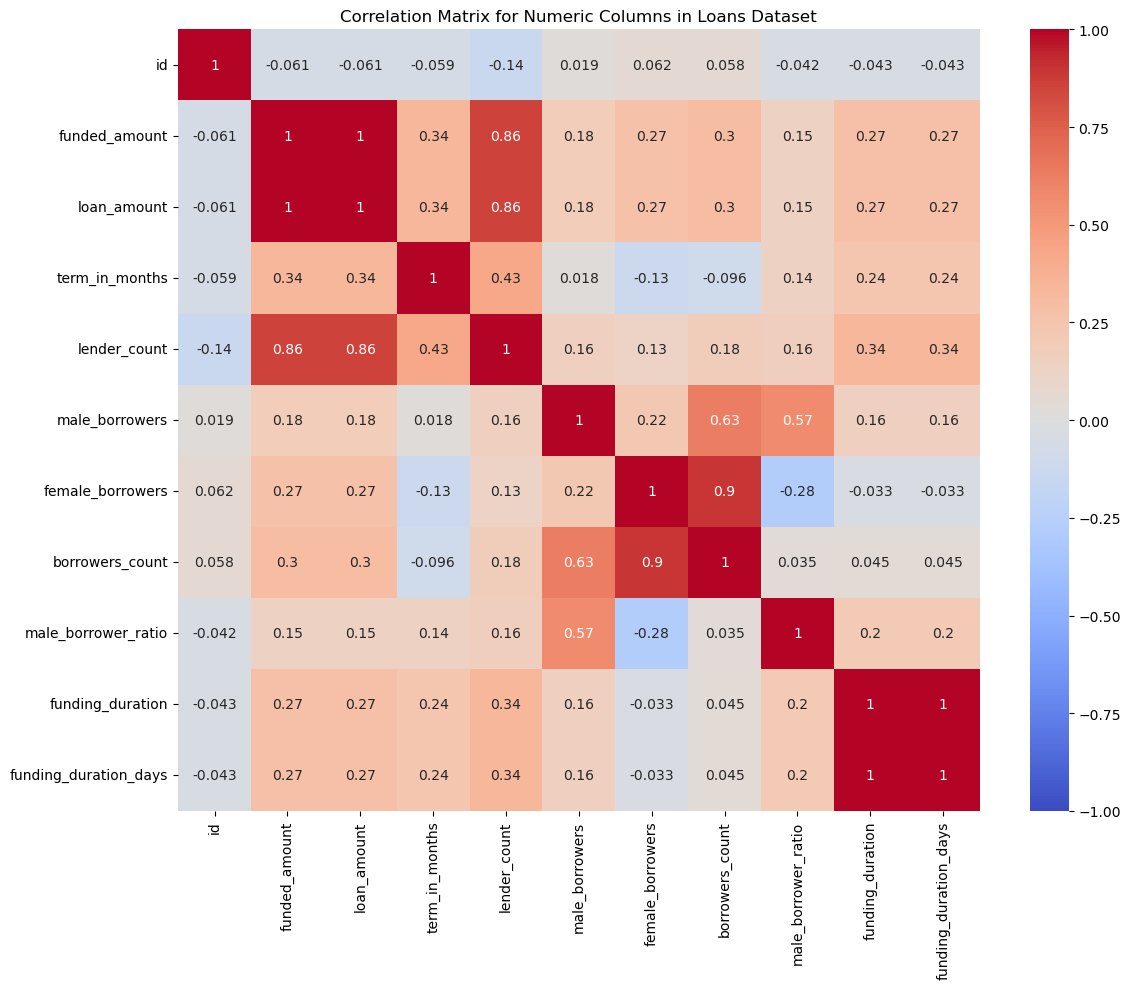

In [250]:
# it's a good idea to check the correlation matrix, to check if relevant columns may correlate to much with others
numeric_columns = loans.select_dtypes(include=[np.number]).columns

# Beregn korrelationsmatrix
corr_matrix = loans[numeric_columns].corr()

# Plot korrelationsmatrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix for Numeric Columns in Loans Dataset')
plt.tight_layout()
plt.show()

In [251]:
data_clean.head()

,id,funded_amount,loan_amount,activity,sector,country,region,posted_time,disbursed_time,funded_time,...,repayment_interval,date,male_borrowers,female_borrowers,borrowers_count,male_borrower_ratio,gender_class,outlier_loan_amount,funding_duration,funding_duration_days
0,653051,300.0,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,...,irregular,2014-01-01,0,1,1,0.0,female(s),False,1 days 03:53:53,1.162419
1,653053,575.0,575.0,Rickshaw,Transportation,Pakistan,Lahore,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,...,irregular,2014-01-01,0,2,2,0.0,female(s),False,1 days 02:26:15,1.101562
3,653063,200.0,200.0,Embroidery,Arts,Pakistan,Lahore,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,...,irregular,2014-01-01,0,1,1,0.0,female(s),False,0 days 04:56:49,0.206123
4,653084,400.0,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,...,monthly,2014-01-01,0,1,1,0.0,female(s),False,0 days 07:25:32,0.309398
7,653078,400.0,400.0,Beauty Salon,Services,Pakistan,Ellahabad,2014-01-01 11:46:01+00:00,2013-12-20 08:00:00+00:00,2014-01-10 18:18:44+00:00,...,monthly,2014-01-01,0,1,1,0.0,female(s),False,9 days 06:32:43,9.272720


In [252]:
#Filtering only the relevant columns for the model
relevant_columns = [
    'loan_amount',
    'activity',
    'sector',
    'country',
    'region',
    'posted_time',
    'funded_time',
    'borrowers_count',
    'gender_class',
    'funding_duration_days',
    'term_in_months',
]


In [253]:
loans_df = loans[relevant_columns]

### Data Imbalance for country
Some countries account for more data than others, which could lead to imbalanced models.

In [254]:
print(loans_df['country'].value_counts().to_string())

country
Philippines                             157479
Kenya                                    61530
Cambodia                                 33254
Pakistan                                 24854
Peru                                     18362
Uganda                                   17787
Tajikistan                               17259
Colombia                                 17203
El Salvador                              16503
Ecuador                                  12496
Nicaragua                                 9677
Vietnam                                   8902
Palestine                                 6510
Armenia                                   6119
Paraguay                                  6114
Lebanon                                   5939
Guatemala                                 5536
Bolivia                                   5035
Mexico                                    3698
The Democratic Republic of the Congo      1268


In [239]:
# check initial distribution of countries
print("Country distribution:")
print(loans_df['country'].value_counts())

# Initialize RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=9000)

# Apply resampling using 'room_type' as a balancing feature
X_resampled, _ = rus.fit_resample(loans_df, loans_df['country'])

print("Country distribution after balancing:")
print(X_resampled['country'].value_counts())

# updating dataframe
loans_df = X_resampled

Country distribution:
country
Bolivia                                 270
Peru                                    269
Philippines                             269
Armenia                                 264
Nicaragua                               260
Guatemala                               258
Palestine                               258
The Democratic Republic of the Congo    255
Pakistan                                252
Ecuador                                 251
Colombia                                249
Uganda                                  249
Mexico                                  247
Kenya                                   245
El Salvador                             244
Lebanon                                 243
Cambodia                                236
Tajikistan                              232
Paraguay                                227
Vietnam                                 222
Name: count, dtype: int64
Country distribution after balancing:
country
Armenia           

In [255]:
#SAMPLING IS OPTIONAL?
# loans_df = loans_df.sample(n=10000, random_state=9000)

### Setting up the target and feature variables + splitting data

In [256]:
# define the target variable 'y' (loan_amount)
y = loans_df['loan_amount']

# define the feature set 'X' (all other columns except loan_amount)
X = loans_df[['activity', 'sector', 'country', 'borrowers_count', 'funding_duration_days', 'region', 'gender_class', 'term_in_months']]

# preprocessing for numeric features
numeric_features = ['borrowers_count', 'funding_duration_days', 'term_in_months']
numeric_transformer = StandardScaler()

# preprocessing for categorical features
categorical_features = ['activity', 'sector', 'country', 'region', 'gender_class']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

### Creating pipelines

In [257]:
# Pipeline for Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Pipeline for Decision Tree Regression
pipeline_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])

# Pipeline for Random Forest Regression
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])
 
# Pipeline for XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

### Model Training without hyperparameterization

In [258]:
############################################################
# Train Linear Regression
pipeline_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = pipeline_lr.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Train & test score
train_score_lr = pipeline_lr.score(X_train, y_train)
test_score_lr = pipeline_lr.score(X_test, y_test)

print("Linear Regression Performance:")
print(f"  MSE: {mse_lr:.4f}")
print(f"  MAE: {mae_lr:.4f}")
print(f"  R²: {r2_lr:.4f}")
print(f"Train Score: {train_score_lr:.4f}")
print(f"Test Score: {test_score_lr:.4f}")

############################################################
# Train Random Forest Regression
pipeline_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Train & test score
train_score_rf = pipeline_rf.score(X_train, y_train)
test_score_rf = pipeline_rf.score(X_test, y_test)

print("\nRandom Forest Regression Performance:")
print(f"  MSE: {mse_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
print(f"  R²: {r2_rf:.4f}")
print(f"Train Score: {train_score_rf:.4f}")
print(f"Test Score: {test_score_rf:.4f}")

############################################################
# Train XGBoost Regression
pipeline_xgb.fit(X_train, y_train)

# Make predictions
y_pred_rf = pipeline_xgb.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Train & test score
train_score_rf = pipeline_xgb.score(X_train, y_train)
test_score_rf = pipeline_xgb.score(X_test, y_test)

print("\nXGBoost Performance:")
print(f"  MSE: {mse_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
print(f"  R²: {r2_rf:.4f}")
print(f"Train Score: {train_score_rf:.4f}")
print(f"Test Score: {test_score_rf:.4f}")

############################################################

Linear Regression Performance:
  MSE: 96651.9152
  MAE: 213.3503
  R²: 0.5450
Train Score: 0.7481
Test Score: 0.5450

Decision Tree Regression Performance:
  MSE: 121728.9583
  MAE: 230.6083
  R²: 0.4270
Train Score: 1.0000
Test Score: 0.4270

Random Forest Regression Performance:
  MSE: 81063.7946
  MAE: 190.1092
  R²: 0.6184
Train Score: 0.9470
Test Score: 0.6184

XGBoost Performance:
  MSE: 77846.1145
  MAE: 193.1259
  R²: 0.6336
Train Score: 0.7969
Test Score: 0.6336


### Hyperparamter tuning using cross-validation

#### Random Forest Hyperparameter tuning

In [260]:
# RANDOM FOREST TREE - HYPERPARAMETER TUNING
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define a smaller hyperparameter space for randomized search
param_distributions = {
    'regressor__n_estimators': [100, 150, 200],  # Fewer options for number of trees
    'regressor__max_depth': [10, 20, 30],  # Fewer options for max depth
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 3]
}

# Create the RandomizedSearchCV object with fewer iterations but keeping cv=5
random_search = RandomizedSearchCV(estimator=pipeline_rf, param_distributions=param_distributions,
                                   n_iter=5, cv=5, n_jobs=-1, scoring='r2', verbose=1, random_state=69)

# Perform randomized search on the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and R^2 score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best cross-validation R^2 score: {random_search.best_score_}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best hyperparameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}
Best cross-validation R^2 score: 0.6229925304126114


#### XGBoost Hyperparameter tuning

In [261]:
# XGBOOST - HYPERPARAMETER TUNING
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# Define the hyperparameter space for randomized search
param_distributions = {
    'regressor__n_estimators': np.arange(100, 1001, 100),  # Number of trees
    'regressor__max_depth': np.arange(3, 11),  # Maximum tree depth
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.3],  # Learning rate
    'regressor__subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'regressor__min_child_weight': [1, 3, 5]  # Minimum sum of instance weight needed in a child
}

# Create the XGBoost regressor
xgb_regressor = XGBRegressor(random_state=69)

# Assuming you have a pipeline, replace 'pipeline_rf' with your XGBoost pipeline
# If you don't have a pipeline, you can use the XGBRegressor directly
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),  # Your preprocessor steps
    ('regressor', xgb_regressor)
])

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=pipeline_xgb, param_distributions=param_distributions,
                                   n_iter=10, cv=5, n_jobs=-1, scoring='r2', verbose=1, random_state=69)

# Perform randomized search on the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and R^2 score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best cross-validation R^2 score: {random_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'regressor__subsample': 0.8, 'regressor__n_estimators': 200, 'regressor__min_child_weight': 1, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 1.0}
Best cross-validation R^2 score: 0.6381983925741219


In [263]:
# Pipeline for Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Pipeline for Random Forest Regression
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=150, 
                                        min_samples_split=10, 
                                        min_samples_leaf=3, 
                                        max_depth=40))
])


# Pipeline for XGBoost Regression
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor( subsample=0.8, 
                                n_estimators= 200, 
                                min_child_weight= 1, 
                                max_depth=34,
                                learning_rate= 0.1,
                                colsample_bytree= 1))
])

### Hyperparameter tunned models

In [264]:
# RANDOM TREE FOREST
# perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='r2')

# train the model on the full training set
pipeline_rf.fit(X_train, y_train)

# evaluate the model on training and test data
train_score_rf = pipeline_rf.score(X_train, y_train)
test_score_rf = pipeline_rf.score(X_test, y_test)

# calculate MSE and RMSE
y_pred_rf = pipeline_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# print cross-validation scores and the final evaluation
print(f"Random Forest")
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R^2: {cv_scores.mean()}")
print(f'Random Forest - Training R^2 score: {train_score_rf}')
print(f'Random Forest - Test R^2 score: {test_score_rf}')
print(f'Random Forest - Test MSE: {mse_rf}')
print(f'Random Forest - Test RMSE: {rmse_rf}')

####################################################################################
# XGBoost

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=5, scoring='r2')

# Train the model on the full training set
pipeline_xgb.fit(X_train, y_train)

# Evaluate the model on training and test data
train_score_rf = pipeline_xgb.score(X_train, y_train)
test_score_rf = pipeline_xgb.score(X_test, y_test)

# Calculate MSE and RMSE
y_pred_rf = pipeline_xgb.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Print cross-validation scores and the final evaluation
print(f"XGBoost")
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R^2: {cv_scores.mean()}")
print(f'XGBoost - Training R^2 score: {train_score_rf}')
print(f'XGBoost - Test R^2 score: {test_score_rf}')
print(f'XGBoost - Test MSE: {mse_rf}')
print(f'XGBoost - Test RMSE: {rmse_rf}')

Random Forest
Cross-Validation R^2 Scores: [0.62006446 0.67475725 0.59177616 0.65872934 0.59338581]
Mean Cross-Validation R^2: 0.6277426023245896
Random Forest - Training R^2 score: 0.8097709776966864
Random Forest - Test R^2 score: 0.6243783847512947
Random Forest - Test MSE: 79798.78161173902
Random Forest - Test RMSE: 282.4867813044338
XGBoost
Cross-Validation R^2 Scores: [0.5452385  0.63374123 0.57031712 0.59658546 0.54973507]
Mean Cross-Validation R^2: 0.5791234754660621
Random Forest - Training R^2 score: 0.99307331056161
Random Forest - Test R^2 score: 0.5764457841802231
Random Forest - Test MSE: 89981.80348741324
Random Forest - Test RMSE: 299.96967094593623
